C:\cygwin64\tmp\ipykernel_17968\3062114517.py:16: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(AdaptiveDenseWithPathTracking, self).__init__(**kwargs)


=== ОБУЧЕНИЕ С ОТСЛЕЖИВАНИЕМ ПУТЕЙ ===
Эпоха 1: 3.56 сек, 225.03 samples/сек
Сила наиболее выраженного пути: 0.007577
Длина пути: 6 узлов
Эпоха 2: 1.17 сек, 682.14 samples/сек
Сила наиболее выраженного пути: 0.011679
Длина пути: 6 узлов
Эпоха 3: 1.44 сек, 554.94 samples/сек
Сила наиболее выраженного пути: 0.017979
Длина пути: 6 узлов
Эпоха 4: 0.69 сек, 1163.22 samples/сек
Сила наиболее выраженного пути: 0.028562
Длина пути: 6 узлов
Эпоха 5: 1.51 сек, 530.66 samples/сек
Сила наиболее выраженного пути: 0.037952
Длина пути: 6 узлов
Эпоха 6: 1.50 сек, 532.53 samples/сек
Сила наиболее выраженного пути: 0.042845
Длина пути: 6 узлов
Эпоха 7: 0.71 сек, 1121.35 samples/сек
Сила наиболее выраженного пути: 0.047685
Длина пути: 6 узлов
Эпоха 8: 0.64 сек, 1259.10 samples/сек
Сила наиболее выраженного пути: 0.051136
Длина пути: 6 узлов
Эпоха 9: 0.55 сек, 1456.66 samples/сек
Сила наиболее выраженного пути: 0.054234
Длина пути: 6 узлов
Эпоха 10: 1.48 сек, 541.11 samples/сек
Сила наиболее выраженного п

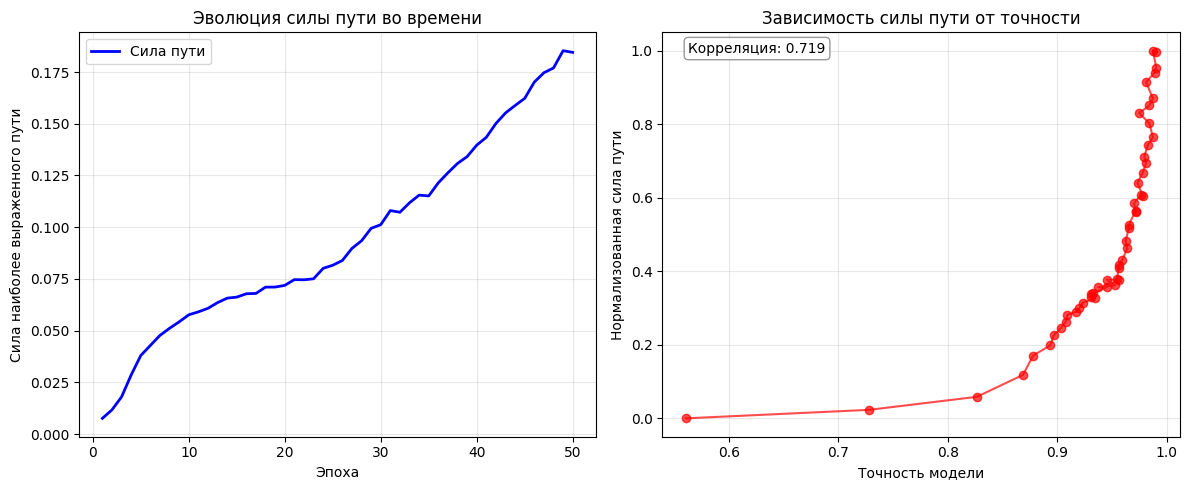


=== АНАЛИЗ ПУТЕЙ ===
Максимальная сила пути: 0.185331
Минимальная сила пути: 0.007577
Средняя сила пути: 0.094954
Корреляция с точностью: 0.719
Сильная положительная корреляция: путь усиливается с ростом точности


C:\Users\goodwin228\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


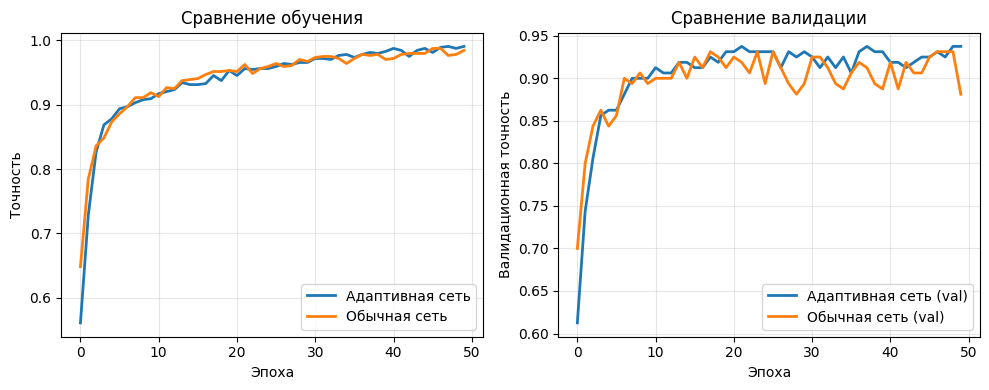

In [7]:
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import networkx as nx
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Кастомный слой с отслеживанием активности нейронов и путей
class AdaptiveDenseWithPathTracking(Layer):
    def __init__(self, units, layer_id, activation='relu', **kwargs):
        super(AdaptiveDenseWithPathTracking, self).__init__(**kwargs)
        self.units = units
        self.layer_id = layer_id
        self.activation = tf.keras.activations.get(activation)
        
    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer='glorot_uniform',
            trainable=True,
            name='kernel'
        )
        self.bias = self.add_weight(
            shape=(self.units,),
            initializer='zeros',
            trainable=True,
            name='bias'
        )
        # Маска активности нейронов (инициализируется единицами)
        self.activity_mask = self.add_weight(
            shape=(self.units,),
            initializer='ones',
            trainable=False,
            name='activity_mask'
        )
        # Счетчик активаций для каждого нейрона
        self.activation_count = self.add_weight(
            shape=(self.units,),
            initializer='zeros',
            trainable=False,
            name='activation_count'
        )
        # Общее количество прошедших данных
        self.total_samples = self.add_weight(
            shape=(),
            initializer='zeros',
            trainable=False,
            name='total_samples'
        )
        
    def call(self, inputs, training=None):
        if training:
            # Вычисляем активации
            output = tf.matmul(inputs, self.kernel) + self.bias
            activated_output = self.activation(output)
            
            # Обновляем статистику активаций
            batch_size = tf.cast(tf.shape(inputs)[0], tf.float32)
            self.total_samples.assign_add(batch_size)
            
            # Считаем среднюю активацию для каждого нейрона в батче
            mean_activation = tf.reduce_mean(tf.cast(activated_output > 0.1, tf.float32), axis=0)
            self.activation_count.assign_add(mean_activation * batch_size)
            
            # Обновляем маску активности (чем больше активаций, тем выше вес)
            activation_ratio = self.activation_count / self.total_samples
            self.activity_mask.assign(activation_ratio)
            
            # Применяем маску к выходу
            masked_output = activated_output * self.activity_mask
            
            return masked_output
        else:
            # Во время инференса просто применяем активацию
            output = tf.matmul(inputs, self.kernel) + self.bias
            activated_output = self.activation(output)
            masked_output = activated_output * self.activity_mask
            return masked_output

# Модифицированная модель с отслеживанием путей
class AdaptiveModelWithPathAnalysis(Sequential):
    def __init__(self, **kwargs):
        super(AdaptiveModelWithPathAnalysis, self).__init__(**kwargs)
        self.path_strengths = []  # Сила наиболее выраженного пути
        self.accuracies = []      # Точность модели
        self.epoch_times = []     # Время обучения
        
    def build_path_network(self):
        """Построение графа нейронной сети"""
        layer_graph = nx.DiGraph()
        
        # Добавляем узлы для входного слоя
        input_size = self.layers[0].kernel.shape[0]
        for i in range(input_size):
            layer_graph.add_node(f'input_{i}', value=1.0, layer=0)
        
        # Добавляем узлы и связи для скрытых слоев
        for layer_idx, layer in enumerate(self.layers):
            if hasattr(layer, 'activity_mask'):
                for neuron_idx in range(layer.units):
                    node_id = f'l{layer_idx}_n{neuron_idx}'
                    layer_graph.add_node(node_id, 
                                      value=layer.activity_mask[neuron_idx].numpy(),
                                      layer=layer_idx + 1)
                    
                    # Связи с предыдущим слоем
                    if layer_idx == 0:
                        # Связь с входным слоем
                        for prev_neuron in range(input_size):
                            weight = layer.kernel[prev_neuron, neuron_idx].numpy()
                            if abs(weight) > 0.001:  # Только значимые связи
                                layer_graph.add_edge(f'input_{prev_neuron}', node_id, 
                                                   weight=abs(weight))
                    else:
                        # Связь с предыдущим скрытым слоем
                        prev_layer = self.layers[layer_idx - 1]
                        for prev_neuron in range(prev_layer.units):
                            weight = layer.kernel[prev_neuron, neuron_idx].numpy()
                            if abs(weight) > 0.001:  # Только значимые связи
                                layer_graph.add_edge(f'l{layer_idx-1}_n{prev_neuron}', node_id, 
                                                   weight=abs(weight))
        
        # Добавляем выходной слой
        output_layer = self.layers[-1]
        for neuron_idx in range(output_layer.units):
            node_id = f'output_{neuron_idx}'
            layer_graph.add_node(node_id, value=1.0, layer=len(self.layers))
            
            # Связи с последним скрытым слоем
            last_hidden = self.layers[-2]
            for prev_neuron in range(last_hidden.units):
                weight = output_layer.kernel[prev_neuron, neuron_idx].numpy()
                if abs(weight) > 0.001:
                    layer_graph.add_edge(f'l{len(self.layers)-2}_n{prev_neuron}', node_id, 
                                      weight=abs(weight))
        
        return layer_graph
    
    def find_strongest_path(self):
        """Поиск наиболее сильного пути через сеть"""
        layer_graph = self.build_path_network()
        
        strongest_path = None
        max_strength = -1
        
        # Поиск путей от входных нейронов к выходным
        input_nodes = [n for n in layer_graph.nodes if layer_graph.nodes[n]['layer'] == 0]
        output_nodes = [n for n in layer_graph.nodes if layer_graph.nodes[n]['layer'] == len(self.layers)]
        
        for start_node in input_nodes:
            for end_node in output_nodes:
                try:
                    # Находим все простые пути
                    for path in nx.all_simple_paths(layer_graph, start_node, end_node):
                        path_strength = 1.0
                        # Вычисляем силу пути как произведение весов связей и активности нейронов
                        for i in range(len(path) - 1):
                            if layer_graph.has_edge(path[i], path[i+1]):
                                edge_weight = layer_graph[path[i]][path[i+1]]['weight']
                                neuron_value = layer_graph.nodes[path[i+1]]['value']
                                path_strength *= edge_weight * neuron_value
                        
                        if path_strength > max_strength:
                            max_strength = path_strength
                            strongest_path = path
                except nx.NetworkXNoPath:
                    continue
        
        return strongest_path, max_strength
    
    def analyze_network_paths(self, accuracy):
        """Анализ путей и сохранение статистики"""
        path, strength = self.find_strongest_path()
        self.path_strengths.append(strength if strength > 0 else 0)
        self.accuracies.append(accuracy)
        return path, strength

# Callback для измерения скорости и анализа путей
class PathAnalysisCallback(Callback):
    def __init__(self, custom_model):
        super().__init__()
        self.custom_model = custom_model
        self.epoch_start_time = None
        self.epoch_times = []
        self.samples_per_sec = []
    
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()
    
    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_time)
        sps = len(X_train) / epoch_time
        self.samples_per_sec.append(sps)
        
        # Анализ путей после каждой эпохи
        accuracy = logs.get('accuracy', 0) if logs else 0
        path, strength = self.model.analyze_network_paths(accuracy)
        
        print(f"Эпоха {epoch+1}: {epoch_time:.2f} сек, {sps:.2f} samples/сек")
        print(f"Сила наиболее выраженного пути: {strength:.6f}")
        if path:
            print(f"Длина пути: {len(path)} узлов")

# Генерация данных
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, 
                          n_informative=15, n_redundant=5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

# Создание адаптивной нейронной сети с отслеживанием путей
model = AdaptiveModelWithPathAnalysis()
model.add(AdaptiveDenseWithPathTracking(10, layer_id=0, input_dim=X_train.shape[1], activation='relu'))
model.add(AdaptiveDenseWithPathTracking(8, layer_id=1, activation='relu'))
model.add(AdaptiveDenseWithPathTracking(8, layer_id=2, activation='relu'))
model.add(AdaptiveDenseWithPathTracking(8, layer_id=3, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Компиляция модели
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Обучение с отслеживанием путей
print("=== ОБУЧЕНИЕ С ОТСЛЕЖИВАНИЕМ ПУТЕЙ ===")
path_callback = PathAnalysisCallback(model)

history = model.fit(X_train, y_train,
                   epochs=50,
                   batch_size=3,
                   validation_split=0.2,
                   verbose=0,
                   callbacks=[path_callback])

# Визуализация зависимости силы пути от точности
def plot_path_vs_accuracy(path_strengths, accuracies):
    plt.figure(figsize=(12, 5))
    
    # Нормализуем силу пути для лучшего сравнения
    normalized_strength = (path_strengths - np.min(path_strengths)) / (np.max(path_strengths) - np.min(path_strengths) + 1e-10)
    
    plt.subplot(1, 2, 1)
    epochs = range(1, len(path_strengths) + 1)
    plt.plot(epochs, path_strengths, 'b-', label='Сила пути', linewidth=2)
    plt.xlabel('Эпоха')
    plt.ylabel('Сила наиболее выраженного пути')
    plt.title('Эволюция силы пути во времени')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(accuracies, normalized_strength, 'ro-', alpha=0.7)
    plt.xlabel('Точность модели')
    plt.ylabel('Нормализованная сила пути')
    plt.title('Зависимость силы пути от точности')
    
    # Вычисляем корреляцию
    correlation = np.corrcoef(accuracies, normalized_strength)[0, 1]
    plt.annotate(f'Корреляция: {correlation:.3f}', 
                xy=(0.05, 0.95), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Дополнительный анализ
    print(f"\n=== АНАЛИЗ ПУТЕЙ ===")
    print(f"Максимальная сила пути: {max(path_strengths):.6f}")
    print(f"Минимальная сила пути: {min(path_strengths):.6f}")
    print(f"Средняя сила пути: {np.mean(path_strengths):.6f}")
    print(f"Корреляция с точностью: {correlation:.3f}")
    
    # Анализ тенденций
    if correlation > 0.5:
        print("Сильная положительная корреляция: путь усиливается с ростом точности")
    elif correlation > 0.2:
        print("Умеренная положительная корреляция")
    elif correlation > -0.2:
        print("Слабая корреляция")
    else:
        print("Отрицательная корреляция")

# Построение графиков
plot_path_vs_accuracy(model.path_strengths, model.accuracies)

# Дополнительная визуализация: сравнение с обычным обучением
def compare_with_standard_training():
    """Сравнение с обычной сетью без адаптивности"""
    standard_model = Sequential()
    standard_model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
    standard_model.add(Dense(8, activation='relu'))
    standard_model.add(Dense(8, activation='relu'))
    standard_model.add(Dense(8, activation='relu'))
    standard_model.add(Dense(1, activation='sigmoid'))
    
    standard_model.compile(optimizer=Adam(learning_rate=0.001),
                         loss='binary_crossentropy',
                         metrics=['accuracy'])
    
    standard_history = standard_model.fit(X_train, y_train,
                                        epochs=50,
                                        batch_size=3,
                                        validation_split=0.2,
                                        verbose=0)
    
    # Сравнение точности
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Адаптивная сеть', linewidth=2)
    plt.plot(standard_history.history['accuracy'], label='Обычная сеть', linewidth=2)
    plt.xlabel('Эпоха')
    plt.ylabel('Точность')
    plt.title('Сравнение обучения')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['val_accuracy'], label='Адаптивная сеть (val)', linewidth=2)
    plt.plot(standard_history.history['val_accuracy'], label='Обычная сеть (val)', linewidth=2)
    plt.xlabel('Эпоха')
    plt.ylabel('Валидационная точность')
    plt.title('Сравнение валидации')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Запуск сравнения
compare_with_standard_training()